In [15]:
import pandas as pd

In [16]:
import torch

In [17]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader

In [18]:
import cv2
from skimage import io

In [19]:
import os

In [54]:
df=pd.read_csv("/content/drive/MyDrive/Xen.ai/tumor_location.csv")

In [55]:
df['size']=df['size']*34/2048

In [56]:
df['x']=df['x']/2048
df['y']=df['y']/2048

In [57]:
train=df.sample(frac=0.8)

In [58]:
test=df.drop(train.index).sample(frac=1)

In [ ]:
#re=300
#cc=244

In [ ]:
#df['x']=((df['x']*re).astype(int)-int((re-cc)/2))/cc
#df['y']=((df['y']*re).astype(int)-int((re-cc)/2))/cc

In [59]:
train.to_csv("train_localisation_nodule.csv")
test.to_csv("test_localisation_nodule.csv")

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class JSRTdataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.annotations=pd.read_csv(csv_file).drop("Unnamed: 0",axis=1)
        self.root_dir=root_dir
        self.transform=transform
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        img_path=os.path.join(self.root_dir,self.annotations.iloc[index,0])
        image=io.imread(img_path)
        image = cv2.equalizeHist(image)
        image = cv2.medianBlur(image,3)
        tumor_size=torch.tensor(self.annotations.iloc[index,1])
        tumor_x=torch.tensor(self.annotations.iloc[index,2])
        tumor_y=torch.tensor(self.annotations.iloc[index,3])
        if not torch.is_tensor(image):
            image=torchvision.transforms.functional.to_tensor(image)    
        if self.transform:
            image=self.transform(image)
        return (image,tumor_x,tumor_y,tumor_size)

In [ ]:
mean=0.4952
std=0.2934

In [ ]:
transformations = transforms.Compose([
    transforms.Resize(600),
    transforms.CenterCrop(572),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
factor=244/2048

In [ ]:
root_dir="/content/drive/MyDrive/Colab Notebooks/images"
batch_size=4

train_set=JSRTdataset(csv_file="train_localisation_nodule.csv",root_dir=root_dir,transform=transformations)
test_set=JSRTdataset(csv_file="test_localisation_nodule.csv",root_dir=root_dir,transform=transformations)

train_loader=DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


torch.Size([572, 572])
torch.float32


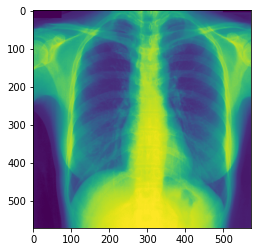

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for images , tumor_x,tumor_y,tumor_size in train_set:
    plt.imshow(images[0])
    print(images[0].shape)
    print(images[0].dtype)
    plt.show()
    break

In [ ]:
for i,data in enumerate(train_loader):
    images , tumor_x,tumor_y,tumor_size = data
    print(images.shape)
    print(tumor_x.shape)
    print(tumor_y.shape)
    print(tumor_size.shape)
    break

torch.Size([4, 1, 572, 572])
torch.Size([4])
torch.Size([4])
torch.Size([4])


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import f1_score
from sklearn.metrics import auc

!python -c "import monai" || pip install -q "monai[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121

model=torch.load
model = densenet121(spatial_dims=2, in_channels=1,
                   out_channels=3)
model.load_state_dict(torch.load("/content/drive/MyDrive/Xen.ai/best_metric_model_1.pth"))
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
val_interval = 1

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 358kB 8.4MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 


In [ ]:
device=torch.device('cpu')

In [ ]:
loss_function = torch.nn.MSELoss()

In [ ]:
max_epochs=200
best_metric = 10
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
root_dir='/content/drive/MyDrive/Xen.ai'
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, x,y,size =batch_data[0], batch_data[1],batch_data[2],batch_data[3]
        optimizer.zero_grad()
        outputs = model(inputs)
        labels=torch.empty((3,outputs.shape[0]))
        labels[0],labels[1],labels[2]=x,y,size
        loss = loss_function(outputs, labels.T)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_set) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_set) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            flag=0
            for val_data in test_loader:
                val_images, val_x,val_y,val_size = (
                    val_data[0].to(device),
                    val_data[1].to(device),val_data[2],val_data[3]
                )
                if flag:
                    y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                    val_label=torch.empty((3,val_images.shape[0]))
                    val_label[0],val_label[1],val_label[2]=val_x,val_y,val_size
                    val_label=val_label.T
                    y = torch.cat([y, val_label], dim=0)
                    val_img_array=torch.cat([val_img_array,val_images],dim=0)
                else:
                    y_pred=model(val_images)
                    y=torch.empty((3,y_pred.shape[0]))
                    y[0],y[1],y[2]=val_x,val_y,val_size
                    y=y.T
                    val_img_array=val_images
                    flag=1
        
            current_loss=loss_function(y,y_pred)
            if  current_loss < best_metric:
                best_metric = current_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current loss: {current_loss:.4f}"
                f" least loss: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, least_loss: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/200
1/30, train_loss: 0.0555
2/30, train_loss: 0.0888
3/30, train_loss: 0.0484
4/30, train_loss: 0.0336
5/30, train_loss: 0.0552
6/30, train_loss: 0.0453
7/30, train_loss: 0.0325
8/30, train_loss: 0.0369
9/30, train_loss: 0.0268
10/30, train_loss: 0.0789
11/30, train_loss: 0.0495
12/30, train_loss: 0.0516
13/30, train_loss: 0.0940
14/30, train_loss: 0.0289
15/30, train_loss: 0.0498
16/30, train_loss: 0.0290
17/30, train_loss: 0.0438
18/30, train_loss: 0.0445
19/30, train_loss: 0.0301
20/30, train_loss: 0.0378
21/30, train_loss: 0.0581
22/30, train_loss: 0.0560
23/30, train_loss: 0.0336
24/30, train_loss: 0.0503
25/30, train_loss: 0.0410
26/30, train_loss: 0.0355
27/30, train_loss: 0.0568
28/30, train_loss: 0.0524
29/30, train_loss: 0.0385
30/30, train_loss: 0.0384
31/30, train_loss: 0.0326
epoch 1 average loss: 0.0469
saved new best metric model
current epoch: 1 current loss: 0.0420 least loss: 0.0420 at epoch: 1
----------
epoch 2/200
1/30, train_loss: 0.0537
2/30, 

In [ ]:
cc=572
re=600

In [ ]:
predicted_x=(y_pred[:,0]*re).numpy().astype(int)
predicted_y=(y_pred[:,1]*re).numpy().astype(int)
predicted_size=(y_pred[:,2]).numpy()*re/34

In [ ]:
predicted_x=(predicted_x*cc).numpy().astype(int)
predicted_y=(predicted_y*cc).numpy().astype(int)
predicted_size=predicted_size.numpy()*cc/34

In [ ]:
y_pred[:,2]*2048

In [ ]:
df['size']*2048/34

In [ ]:
!pip install bbox

In [ ]:
"""from bbox import BBox2D
for images , tumor_x,tumor_y,tumor_size in train_set:
    plt.imshow(images[0])
    box=BBox2D([tumor_x,tumor_y,tumor_size,tumor_size])
    FancyBboxPatch((box.x))
    plt.plot(box)
    plt.show()
    break"""
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms.functional as F
# Create figure and axes


# Display the image
i=0
for images in val_img_array:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(images[0].numpy())
    # Create a Rectangle patch
    rect = patches.Rectangle((int(predicted_x[i]-predicted_size[i]/2), int(predicted_y[i]-predicted_size[i]/2)), predicted_size[i], predicted_size[i], linewidth=2, edgecolor='r', facecolor='none')
    rect1 = patches.Rectangle((int(predicted_x[i]-predicted_size[i]*10/2), int(predicted_y[i]-predicted_size[i]*10/2)), predicted_size[i]*10, predicted_size[i]*10, linewidth=2, edgecolor='r', facecolor='none')

    i=i+1
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.add_patch(rect1) 
    plt.show()
i=0


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from matplotlib.patches import FancyBboxPatch

In [49]:

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [ ]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.subplot(1, 2, 1)
    plt.imshow(gray)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    plt.subplot(1, 2, 2)
    plt.imshow(gray)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

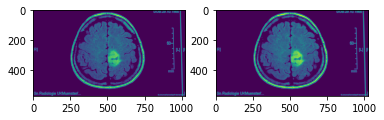

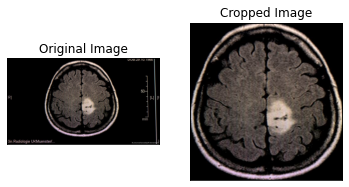

In [ ]:
ex_img = cv2.imread('/content/36871896_101.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [29]:
!python -c "import monai" || pip install -q "monai[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
pd.read_csv('train_localisation_nodule.csv')

,Unnamed: 0,study_id,size,x,y
0,98,JPCLN099.png,0.166016,0.255859,0.246094
1,61,JPCLN062.png,0.249023,0.790039,0.456055
2,93,JPCLN094.png,0.166016,0.251953,0.304199
3,25,JPCLN026.png,0.332031,0.240234,0.332031
4,133,JPCLN134.png,0.265625,0.436035,0.686035
...,...,...,...,...,...
118,55,JPCLN056.png,0.199219,0.270020,0.354004
119,88,JPCLN089.png,0.232422,0.751953,0.220215
120,39,JPCLN040.png,0.249023,0.747070,0.250977
121,58,JPCLN059.png,0.448242,0.275879,0.184082


In [ ]:
train_image_ids=pd.read_csv('train_localisation_nodule.csv')['study_id'].values
test_image_ids=pd.read_csv('test_localisation_nodule.csv')['study_id'].values


array(['JPCLN099.png', 'JPCLN062.png', 'JPCLN094.png', 'JPCLN026.png',
       'JPCLN134.png', 'JPCLN003.png', 'JPCLN047.png', 'JPCLN115.png',
       'JPCLN012.png', 'JPCLN055.png', 'JPCLN051.png', 'JPCLN133.png',
       'JPCLN149.png', 'JPCLN014.png', 'JPCLN067.png', 'JPCLN151.png',
       'JPCLN109.png', 'JPCLN063.png', 'JPCLN142.png', 'JPCLN058.png',
       'JPCLN005.png', 'JPCLN025.png', 'JPCLN146.png', 'JPCLN141.png',
       'JPCLN093.png', 'JPCLN084.png', 'JPCLN035.png', 'JPCLN046.png',
       'JPCLN028.png', 'JPCLN124.png', 'JPCLN098.png', 'JPCLN111.png',
       'JPCLN140.png', 'JPCLN135.png', 'JPCLN006.png', 'JPCLN015.png',
       'JPCLN137.png', 'JPCLN130.png', 'JPCLN072.png', 'JPCLN129.png',
       'JPCLN029.png', 'JPCLN049.png', 'JPCLN088.png', 'JPCLN007.png',
       'JPCLN107.png', 'JPCLN136.png', 'JPCLN144.png', 'JPCLN079.png',
       'JPCLN108.png', 'JPCLN019.png', 'JPCLN017.png', 'JPCLN103.png',
       'JPCLN038.png', 'JPCLN147.png', 'JPCLN020.png', 'JPCLN044.png',
      

In [ ]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import create_test_image_2d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    ToTensord,
)
from monai.visualize import plot_2d_or_3d_image


def main(tempdir):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # create a temporary directory and 40 random image, mask pairs
    print(f"generating synthetic data to {tempdir} (this may take a while)")
    """    for i in range(40):
        im, seg = create_test_image_2d(128, 128, num_seg_classes=1)
        Image.fromarray(im.astype("uint8")).save(os.path.join(tempdir, f"img{i:d}.png"))
        Image.fromarray(seg.astype("uint8")).save(os.path.join(tempdir, f"seg{i:d}.png"))"""
    images = sorted("/content/drive/MyDrive/Colab Notebooks/trans_image/"+train_image_ids) #sorted(glob(os.path.join(tempdir, "img*.png")))
    #print(f"images: ",images)
    segs = sorted("/content/drive/MyDrive/Colab Notebooks/mask_image/"+train_image_ids+"_mask.png")#sorted(glob(os.path.join(tempdir, "seg*.png")))
    #print(f"segmentations",segs)
    train_files = [{"img": img, "seg": seg} for img, seg in zip(images[:-20], segs[:-20])]
    val_files = [{"img": img, "seg": seg} for img, seg in zip(images[-20:], segs[-20:])]

    # define transforms for image and segmentation
    train_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys="img"),
            RandCropByPosNegLabeld(
                keys=["img", "seg"], label_key="seg", spatial_size=[572,572], pos=1, neg=1, num_samples=4
            ),
            RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
            ToTensord(keys=["img", "seg"]),
        ]
    )
    val_transforms = Compose(
        [    
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys="img"),
            ToTensord(keys=["img", "seg"]),
        ]
    )

    # define dataset, data loader
    check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    check_loader = DataLoader(check_ds, batch_size=2, num_workers=4, collate_fn=list_data_collate)
    check_data = monai.utils.misc.first(check_loader)
    print(check_data["img"].shape, check_data["seg"].shape)

    # create a training data loader
    train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    train_loader = DataLoader(
        train_ds,
        batch_size=2,
        shuffle=True,
        num_workers=4,
        collate_fn=list_data_collate,
        pin_memory=torch.cuda.is_available(),
    )
    # create a validation data loader
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=True, reduction="mean")
    post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])
    # create UNet, DiceLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = monai.networks.nets.UNet(
        dimensions=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    writer = SummaryWriter()
    for epoch in range(3):
        print("-" * 3)
        print(f"epoch {epoch + 1}/{1500}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                metric_sum = 0.0
                metric_count = 0
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data["img"].to(device), val_data["seg"].to(device)
                    #print("val_labels: ",val_labels.shape)
                    roi_size = (572,572)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = post_trans(val_outputs)
                    #print("val_outputs: ",val_outputs.shape)
                    value, _ = dice_metric(y_pred=val_outputs, y=val_labels)
                    metric_count += len(value)
                    metric_sum += value.item() * len(value)
                metric = metric_sum / metric_count
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), "best_metric_model_segmentation2d_dict.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
                
                plt.figure(figsize=(10,10))
                plt.subplot(1,3,1)
                plt.imshow(val_images[0][0].cpu())
                plt.subplot(1,3,2)
                plt.imshow(val_labels[0][0].cpu())
                plt.subplot(1,3,3)
                plt.imshow(val_outputs[0][0].cpu())

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()

if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tempdir:
        main(tempdir)

In [ ]:
img,seg=create_test_image_2d(128, 128, num_seg_classes=1)

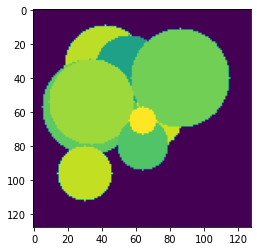

In [ ]:
plt.imshow(img)

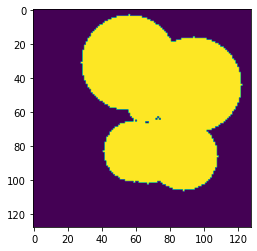

In [ ]:
plt.imshow(seg)

In [ ]:
os.path.join("/content/drive/MyDrive/Colab Notebooks/images", "img*.png")

'/content/drive/MyDrive/Colab Notebooks/images/img*.png'

In [ ]:
"/content/drive/MyDrive/Colab Notebooks/images/"+train_image_ids

array(['/content/drive/MyDrive/Colab Notebooks/images/JPCLN099.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN062.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN094.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN026.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN134.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN003.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN047.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN115.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN012.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN055.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN051.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN133.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN149.png',
       '/content/drive/MyDrive/Colab Notebooks/images/JPCLN014.png',
       '/content/drive/MyDrive/Col

In [73]:
df1=pd.read_csv("train_localisation_nodule.csv").drop('Unnamed: 0',axis=1)
def create_mask(df1):
  for index in range(df1.shape[0]):
    x=df1.loc[index,"x"]
    y=df1.loc[index,"y"]
    size=df1.loc[index,"size"]
    mask=np.zeros([572,572],dtype='uint8')
    x=int((x*2048-(2048-1952.43)/2)*572/1952.43)
    y=int((y*2048-(2048-1952.43)/2)*572/1952.43)
    radius=int((size*572)/34/2)
    cv2.circle(mask, (x, y), radius, 255, -1)
    plt.imshow(mask)
    from PIL import Image
    im = Image.fromarray(mask)
    im.save("/content/drive/MyDrive/Colab Notebooks/mask_image/"+df1.loc[index,"study_id"]+"_mask.png")

    


In [74]:
df1=pd.read_csv("train_localisation_nodule.csv").drop('Unnamed: 0',axis=1)
def create_mask(df1):
  for index in range(df1.shape[0]):
    x=df1.loc[index,"x"]
    y=df1.loc[index,"y"]
    size=df1.loc[index,"size"]
    mask=np.zeros([572,572],dtype='uint8')
    x=int((x*2048-(2048-1952.43)/2)*572/1952.43)
    y=int((y*2048-(2048-1952.43)/2)*572/1952.43)
    radius=int((size*572/34)/2)
    cv2.circle(mask, (x, y), radius, 255, -1)
    plt.imshow(mask)
    from PIL import Image
    im = Image.fromarray(mask)
    im.save("/content/drive/MyDrive/Colab Notebooks/mask_image/"+df1.loc[index,"study_id"]+"_mask.png")

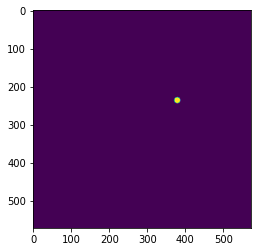

In [75]:
create_mask(df1)

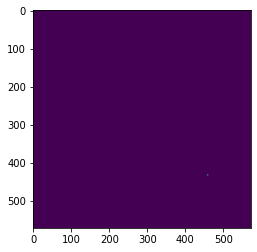

In [76]:
df2=pd.read_csv("test_localisation_nodule.csv").drop('Unnamed: 0',axis=1)

create_mask(df2)

In [ ]:
mask = np.zeros(image.shape[:2], dtype="uint8")
x=int((x*2048-(2048-1952.43)/2)*572/1952.43)
y=int((y*2048-(2048-1952.43)/2)*572/1952.43)
radius=(size*572/34)/2
cv2.circle(mask, (x*, 200), 100, 255, -1)
masked = cv2.bitwise_and(image, image, mask=mask)

In [ ]:
images.shape

torch.Size([4, 1, 572, 572])

In [ ]:
tumor_x

tensor([0.2480, 0.2778, 0.2520, 0.6938], dtype=torch.float64)

In [ ]:
tumor_y

tensor([0.6738, 0.3501, 0.3042, 0.5400], dtype=torch.float64)

In [ ]:
train_image_ids=pd.read_csv('train_localisation_nodule.csv')['study_id'].values

In [ ]:
sample_image=io.imread(os.path.join("/content/drive/MyDrive/Colab Notebooks/images",train_image_ids[2]))


In [ ]:
x_real=pd.read_csv('train_localisation_nodule.csv')['x'][2]
y_real=pd.read_csv('train_localisation_nodule.csv')['y'][2]
size_real=pd.read_csv('train_localisation_nodule.csv')['size'][2]

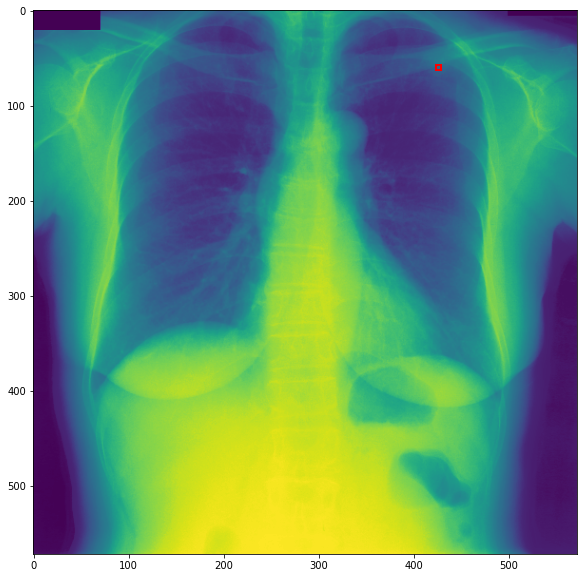

In [ ]:
i=0
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(sample_image)
# Create a Rectangle patch
x=int((tumor_x[i]*2048-(2048-1952.43)/2)*572/1952.43)
y=int((tumor_y[i]*2048-(2048-1952.43)/2)*572/1952.43)
l=tumor_size[i]*572/34
b=tumor_size[i]*572/34
rect = patches.Rectangle((x, y), l, b, linewidth=2, edgecolor='r', facecolor='none')
#rect1 = patches.Rectangle((int((tumor_x[i]-tumor_size[i]*10/2)*572), int((tumor_y[i]-tumor_size[i]*10/2)*572)), tumor_size[i]*10*572, tumor_size[i]*10, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
#ax.add_patch(rect1)
plt.imshow(images[i][0].numpy())
plt.show()

In [ ]:
tumor_size

tensor([0.4150, 0.3320, 0.1660, 0.3320], dtype=torch.float64)

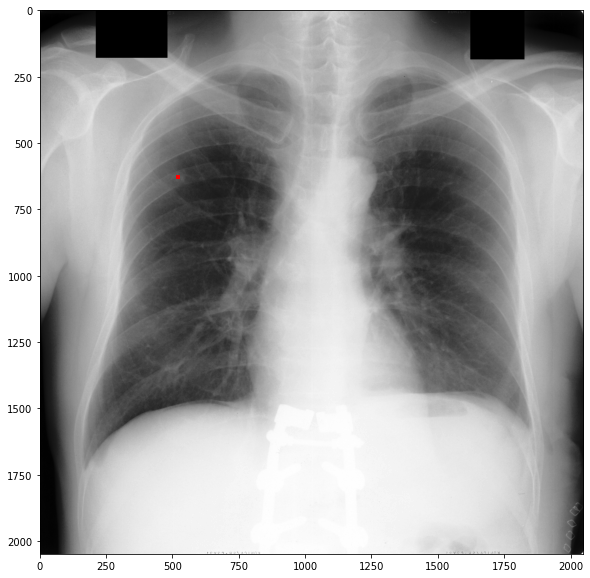

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(sample_image,cmap='gray')
rect = patches.Rectangle((int(x_real*2048), int(y_real*2048)), size_real*2048/34, size_real*2048/34, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
#ax.add_patch(rect1)
plt.show()

In [ ]:
from PIL import Image
sample_image_transformed=torchvision.transforms.CenterCrop(572)(torchvision.transforms.Resize(size=600)(Image.fromarray(sample_image)))

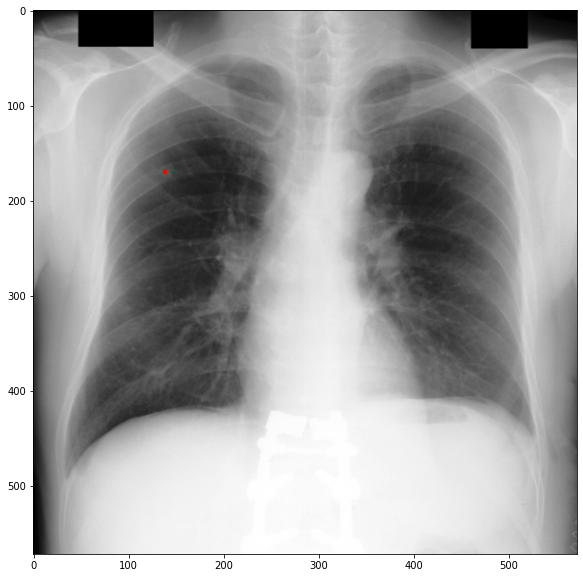

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(sample_image_transformed,cmap='gray')
x=int((x_real*2048-(2048-1952.43)/2)*572/1952.43)
y=int((y_real*2048-(2048-1952.43)/2)*572/1952.43)
l=size_real*572/34
b=size_real*572/34
rect = patches.Rectangle((x, y), l, b, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
#ax.add_patch(rect1)
plt.show()

In [62]:
for image_id in train_image_ids: 
  image=io.imread("/content/drive/MyDrive/Colab Notebooks/images/"+image_id)
  im=torchvision.transforms.CenterCrop(572)(torchvision.transforms.Resize(size=600)(Image.fromarray(image)))
  im.save("/content/drive/MyDrive/Colab Notebooks/trans_image/"+image_id)